In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
import random
from google.colab.patches import cv2_imshow
from google.colab import files
from matplotlib import figure
from tqdm import tqdm

In [17]:
#Load Images
def load_image(image_path):
    # Load an image
    image = cv.imread(image_path)
    return image

def get_gray_image(image):
      gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
      gray = cv.normalize(gray,dst=None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8UC1)
      return gray

In [18]:
#load
image1 = load_image("/content/Set1/1.jpg")
gray1 = get_gray_image(image1)

image2 = load_image("/content/Set1/2.jpg")
gray2 = get_gray_image(image2)

image3 = load_image("/content/Set1/3.jpg")
gray3 = get_gray_image(image3)

In [19]:
def get_ANMScorners(grayimage,N_best, min_dist):
  dst = cv.cornerHarris(grayimage,2,3,0.04)

  anms_img = []
  anms_corners = []

  local_maximas = peak_local_max(dst, min_dist,exclude_border=20)
  n_strong = local_maximas.shape[0]
  r = [np.Infinity for i in range(n_strong)]
  x=np.zeros((n_strong,1))
  y=np.zeros((n_strong,1))
  eu_dist = 0

  for i in range(n_strong):
    x_i = local_maximas[i][0]
    y_i = local_maximas[i][1]
    for j in range(n_strong):
      x_j = local_maximas[j][0]
      y_j = local_maximas[j][1]

      if(dst[x_j, y_j] > dst[x_i, y_i]):
        eu_dist = np.square(x_j - x_i) + np.square(y_j - y_i)
      if r[i] > eu_dist:
        r[i] = eu_dist
        x[i] = x_j
        y[i] = y_j

  index = np.argsort(r)
  index = np.flip(index)
  index = index[0:N_best]
  if x.shape[0] < N_best:
    N_best = x.shape[0]

  x_best=np.zeros((N_best,1))
  y_best=np.zeros((N_best,1))

  for i in range(N_best):
    x_best[i] = np.intp(y[index[i]])
    y_best[i] = np.intp(x[index[i]])
    cv.circle(grayimage, (int(x_best[i]), int(y_best[i])), 3, (0, 255, 0), -1)

  anms_corner = np.intp(np.concatenate((x_best, y_best), axis = 1))
  anms_corners.append(anms_corner)
  cv2_imshow(grayimage)
  cv.imwrite("anms.png",grayimage)
  return anms_img,anms_corner

<ipython-input-19-f5e1f40d1fb4>:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cv.circle(grayimage, (int(x_best[i]), int(y_best[i])), 3, (0, 255, 0), -1)


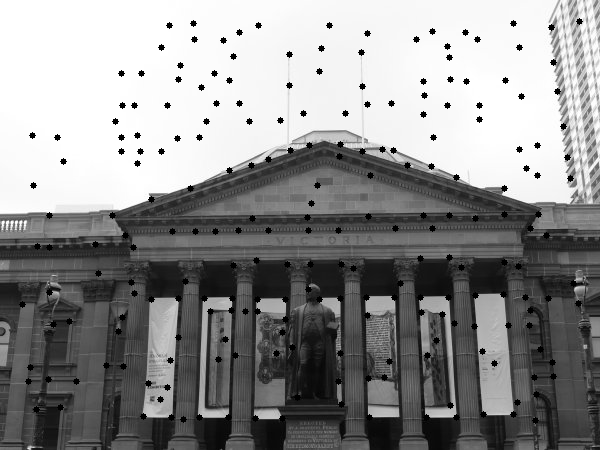

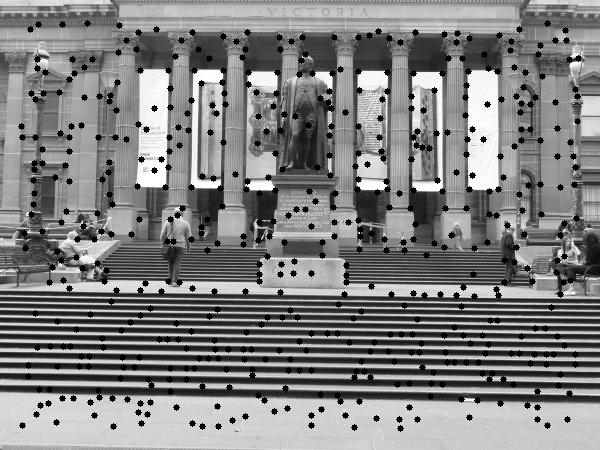

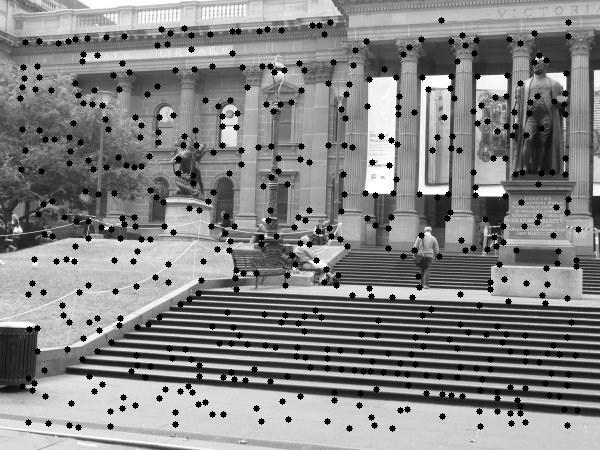

In [20]:
anms_img1, anms_corners1 = get_ANMScorners(gray1, 900, 10)
anms_img2, anms_corners2 = get_ANMScorners(gray2,900,5)
anms_img3, anms_corners3 = get_ANMScorners(gray3,900,5)

In [3]:
def FeatureDesc(anms_corner, grayimage):
    feature_desc = []

    # Apply Gaussian Blur to smooth the image
    grayimage = cv.GaussianBlur(grayimage, (3, 3), 1)
    size_x, size_y = grayimage.shape

    for features in anms_corner:
        # Extract patches with a safe margin
        reqpatch = grayimage[max(0, features[1]-20):min(size_x, features[1]+20):5,
                             max(0, features[0]-20):min(size_y, features[0]+20):5]

        # Ensure the patch size is exactly 8x8 (64 values)
        if reqpatch.size == 64:
            feature_desc.append(reqpatch)

    # Process each patch to create a feature vector
    vec = []
    for im in feature_desc:
        # Flatten the patch and normalize
        im_flat = im.flatten().astype(np.float32)
        im_mean_subtracted = im_flat - np.mean(im_flat)

        var = np.var(im_mean_subtracted)
        if var > 60:
            # Normalize to unit length
            m_abs = im_mean_subtracted / np.sqrt(var)
            vec.append(m_abs.reshape(64, 1))

    return vec

In [21]:
vec1 = FeatureDesc(anms_corners1,gray1)
vec2 = FeatureDesc(anms_corners2,gray2)
vec3 = FeatureDesc(anms_corners3,gray3)

In [34]:
import numpy as np

def Feature_Match(fvector1, fvector2, ratio):
    matches = []
    count = np.zeros(2000)
    for i, vec1 in enumerate(fvector1):
        lowest = None
        second_lowest = None
        lowest_idx = None
        for j, vec2 in enumerate(fvector2):
            dist = np.sum((vec1 - vec2) ** 2)
            if lowest is None or dist < lowest:
                second_lowest = lowest
                lowest = dist
                lowest_idx = j
            elif dist > lowest and (second_lowest is None or dist < second_lowest):
                second_lowest = dist

        if second_lowest is not None and lowest / second_lowest < ratio:
            matches.append((i, lowest_idx))
            count[lowest_idx] += 1

    return matches, count


In [44]:
matches12,count12 = Feature_Match(vec1,vec2,0.45)

matches23, count23 = Feature_Match(vec2,vec3,0.45)

In [49]:
def draw_matches(matches, count, anms_corners1, anms_corners2, gray1, gray2, count_threshold=2):
    key1, key2 = [], []
    for a, b in matches:
        if count[b] < count_threshold:
            key1.append([anms_corners1[a][0], anms_corners1[a][1]])
            key2.append([anms_corners2[b][0], anms_corners2[b][1]])

    key1a = np.array(key1, dtype=float)
    key2a = np.array(key2, dtype=float)
    cv_kpts1 = [cv.KeyPoint(x=k[0], y=k[1], size=1) for k in key1a]
    cv_kpts2 = [cv.KeyPoint(x=k[0], y=k[1], size=1) for k in key2a]

    good_matches = [cv.DMatch(_imgIdx=0, _queryIdx=idx, _trainIdx=idx, _distance=0) for idx in range(len(key1a))]

    drawout = cv.drawMatches(np.uint8(gray1), cv_kpts1, np.uint8(gray2), cv_kpts2, good_matches, outImg=None)
    return drawout,key1a,key2a


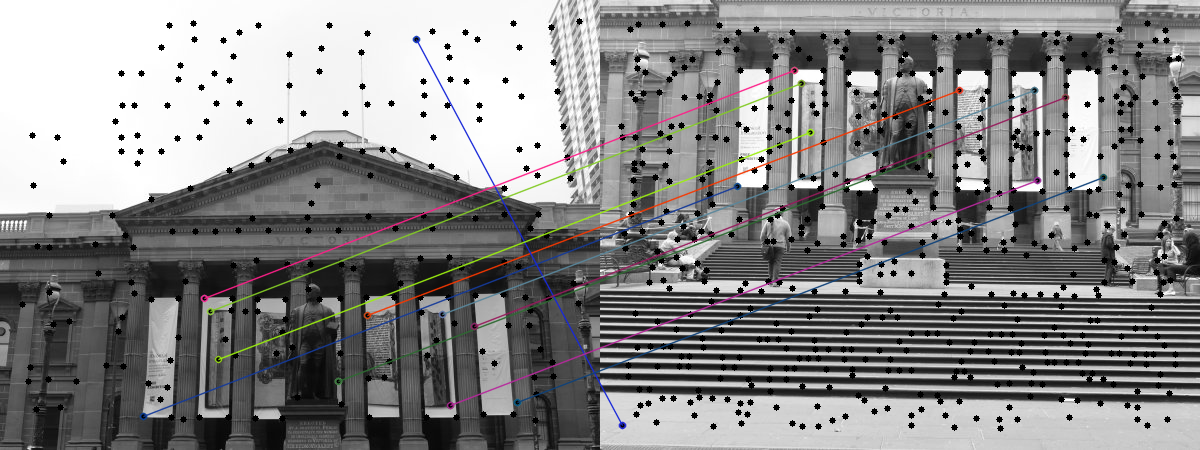

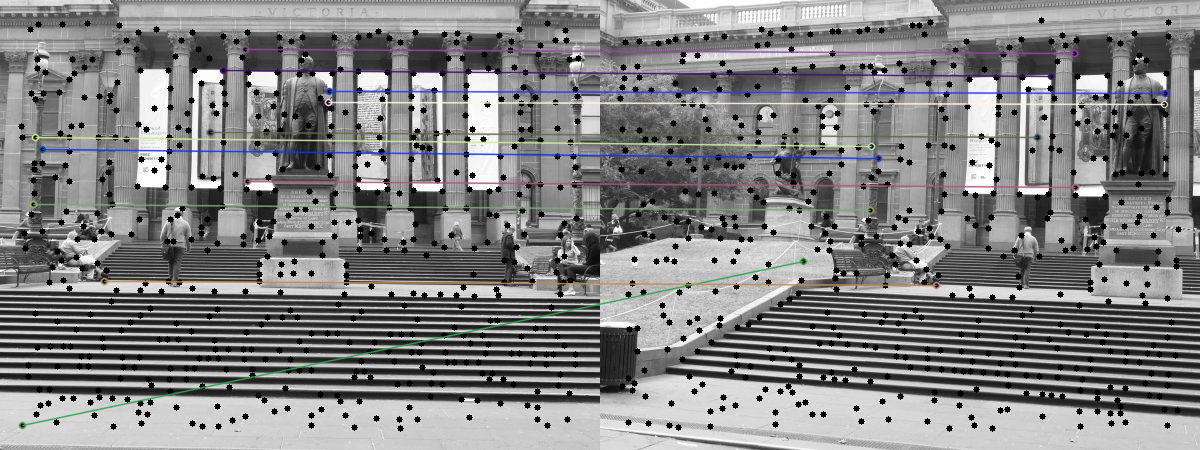

In [51]:
drawout12,key1a_12, key2a_12 = draw_matches(matches12, count12, anms_corners1, anms_corners2, gray1, gray2)
cv2_imshow(drawout12)  # Use cv2.imshow() if not in a Jupyter notebook

drawout23,key1a_23, key2a_23 = draw_matches(matches23, count23, anms_corners2, anms_corners3, gray2, gray3)
(drawout23)

In [54]:
def check_pairs(rand_indices, points1, points2):
    src = points1[rand_indices]
    dst = points2[rand_indices]
    transform_mat, _ = cv.findHomography(src, dst, method=0)
    return transform_mat

def calculate_distance(transform_mat, points1, points2):
    num_points = points1.shape[0]
    points1_homogeneous = np.concatenate([points1, np.ones((num_points, 1))], axis=1)
    transformed_points = np.dot(transform_mat, points1_homogeneous.T).T
    transformed_points /= transformed_points[:, 2][:, np.newaxis]
    distances = np.sqrt(np.sum((transformed_points[:, :2] - points2) ** 2, axis=1))
    return distances

def filterOutliers(key1a, key2a, threshold=5.0, iterations=1000):
    best_model = None
    best_inliers_count = 0
    best_inliers = []

    for _ in range(iterations):
        # Randomly select 4 matches for estimating the transformation
        rand_indices = np.random.choice(key1a.shape[0], 4, replace=False)
        transform_mat = check_pairs(rand_indices, key1a, key2a)

        if transform_mat is not None:
            distances = calculate_distance(transform_mat, key1a, key2a)
            inliers = distances < threshold
            inliers_count = np.sum(inliers)

            if inliers_count > best_inliers_count:
                best_inliers_count = inliers_count
                best_model = transform_mat
                best_inliers = inliers

    # Filter matches based on the best inliers
    filtered_key1a = key1a[best_inliers]
    filtered_key2a = key2a[best_inliers]

    cv_kpts1 = [cv.KeyPoint(x=k[0], y=k[1], size=1) for k in filtered_key1a]
    cv_kpts2 = [cv.KeyPoint(x=k[0], y=k[1], size=1) for k in filtered_key2a]

    good_matches = [cv.DMatch(_imgIdx=0, _queryIdx=idx, _trainIdx=idx, _distance=0) for idx in range(len(filtered_key1a))]

    drawout = cv.drawMatches(np.uint8(gray1), cv_kpts1, np.uint8(gray2), cv_kpts2, good_matches, outImg=None)

    return drawout,filtered_key1a, filtered_key2a, best_model

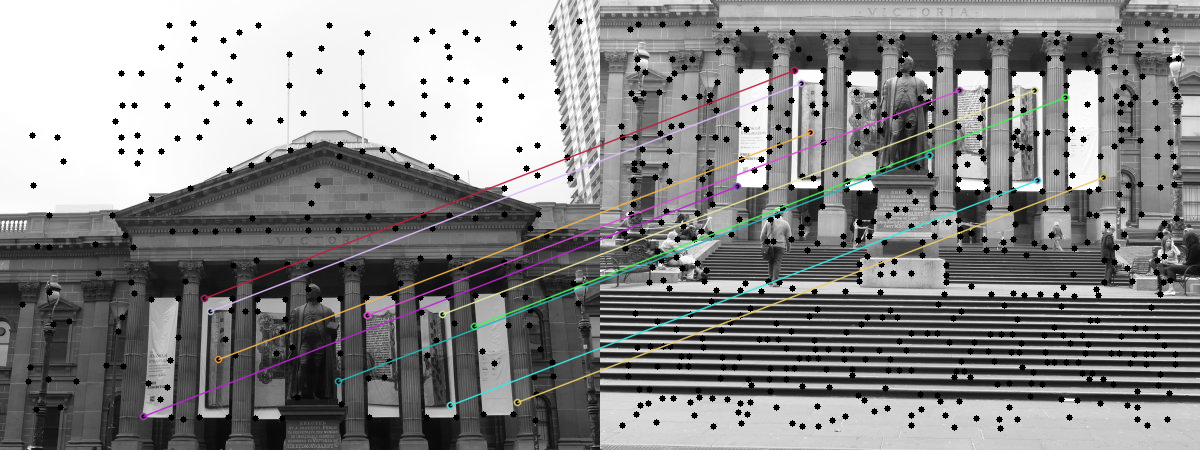

In [56]:
ransac_12, filtered_key1a_12, filtered_key2a_12, tmf_12 = filterOutliers(key1a_12, key2a_12)
cv2_imshow(ransac_12)

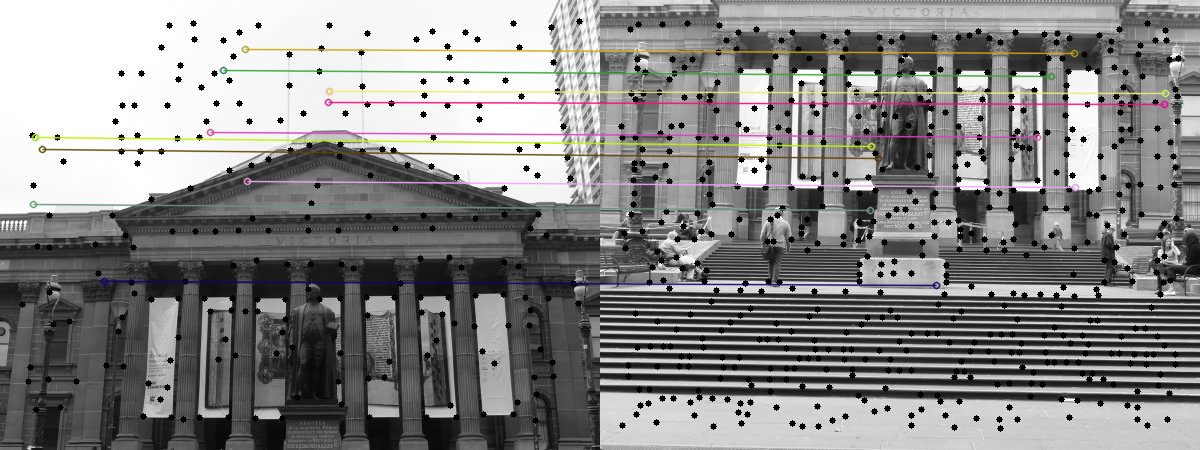

In [57]:
ransac_23, filtered_key1a_23, filtered_key2a_23, tmf_23 = filterOutliers(key1a_23, key2a_23)
cv2_imshow(ransac_23)

In [161]:
tmf_13 = np.dot(tmf_23,tmf_12)

In [132]:
def stitch_img(image1, image2, h_best):
    height_1, width_1 = image1.shape[:2]
    height_2, width_2 = image2.shape[:2]

    corners1 = np.array([[0, width_1, width_1, 0], [0, 0, height_1, height_1], [1, 1, 1, 1]])
    corners1_transformed = np.dot(h_best, corners1)
    corners1_transformed /= corners1_transformed[2]  # Normalize

    x_corners = np.append(corners1_transformed[0], [0, width_2])
    y_corners = np.append(corners1_transformed[1], [0, height_2])

    xmin, xmax = np.min(x_corners), np.max(x_corners)
    ymin, ymax = np.min(y_corners), np.max(y_corners)

    # Size of the output image
    size = (int(round(xmax - xmin)), int(round(ymax - ymin)))

    translation_mat = np.array([[1, 0, -xmin], [0, 1, -ymin], [0, 0, 1]])
    warped_image = cv.warpPerspective(image1, translation_mat.dot(h_best), dsize=size)

    return warped_image, int(-xmin), int(-ymin)

def blend_images(image_base, image_to_blend, offset_x, offset_y):
    height, width = image_base.shape[:2]
    blended_image = np.zeros((max(height, image_to_blend.shape[0] + offset_y),
                              max(width, image_to_blend.shape[1] + offset_x), 3), dtype=np.uint8)
    blended_image[:height, :width] = image_base

    # Blending area
    for y in range(image_to_blend.shape[0]):
        for x in range(image_to_blend.shape[1]):
            if y + offset_y < height and x + offset_x < width:
                if np.all(blended_image[y + offset_y, x + offset_x] == 0):
                    blended_image[y + offset_y, x + offset_x] = image_to_blend[y, x]
                else:
                    blended_image[y + offset_y, x + offset_x] = (
                        blended_image[y + offset_y, x + offset_x] // 2 + image_to_blend[y, x] // 2
                    )
            elif y + offset_y < blended_image.shape[0] and x + offset_x < blended_image.shape[1]:
                blended_image[y + offset_y, x + offset_x] = image_to_blend[y, x]

    return blended_image


def stitch_and_blend(image1, image2, h_best):
    stitched_img, offset_x, offset_y = stitch_img(image1, image2, h_best)
    blended_img = blend_images(stitched_img, image2, offset_x, offset_y)
    return blended_img

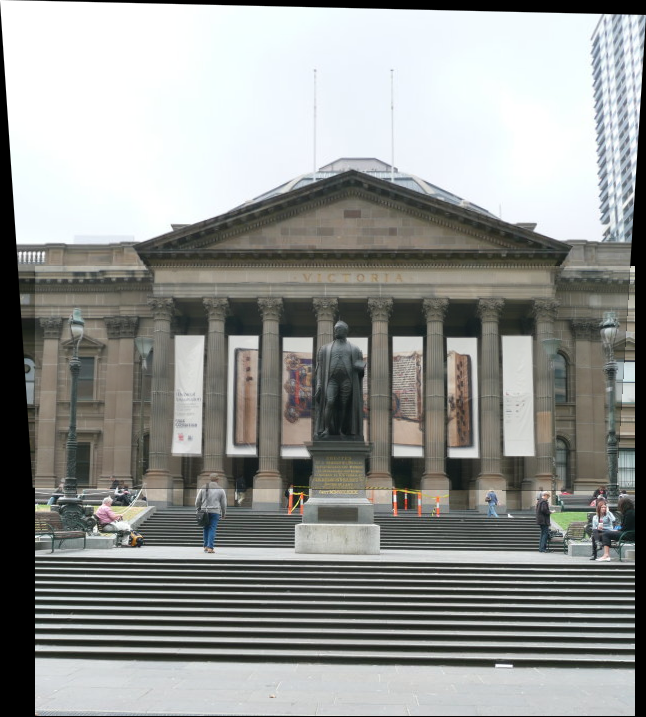

In [120]:
final_image_12 = stitch_and_blend(image1, image2, tmf_12)
cv2_imshow()


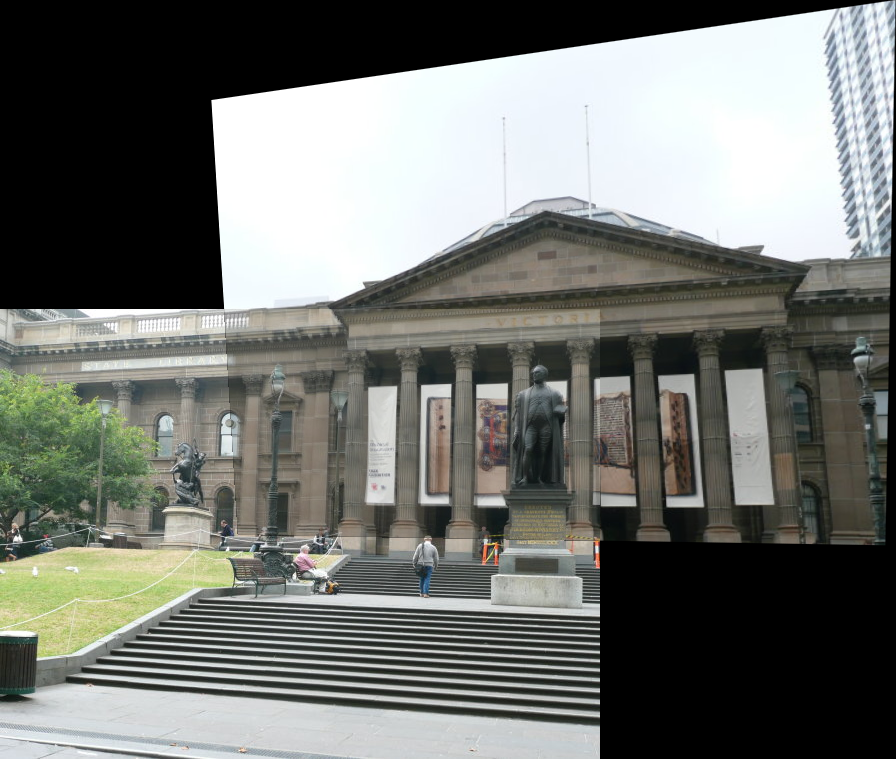

In [135]:
final_image_13 = stitch_and_blend(image1, image3, tmf_13)
cv2_imshow(final_image_13)

In [140]:
def create_final_panorama(image1, image2, image3, tmf_12, tmf_13):
    panorama_12 = stitch_and_blend(image2, image1, tmf_12)
    final_panorama = stitch_and_blend(panorama_12, image3, tmf_13)

    return final_panorama

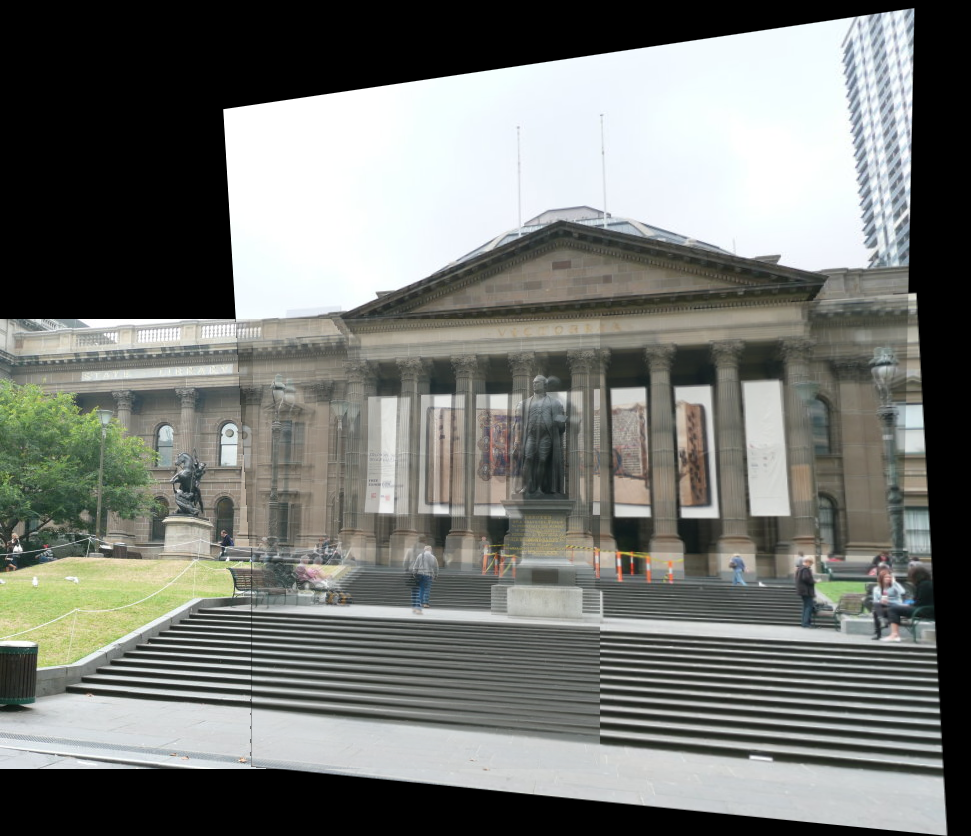

In [162]:
tmf_21 = np.linalg.inv(tmf_12)
final_panorama = create_final_panorama(image1, image2, image3, tmf_21, tmf_13)
cv2_imshow(final_panorama)